<a href="https://colab.research.google.com/github/kzihon/Tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [2]:

# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Mon Aug 21 01:25:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


--2023-08-21 06:59:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-21 06:59:47 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2023-08-21 06:59:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   251MB/s    in 0.6s    

2023-08-21 06:59:52 (251 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [4]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
import tensorflow as tf

IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:

# Check the training data datatype
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[146.12755     76.12755     15.30102   ]
   [159.52551     91.52551     28.525513  ]
   [142.29082     71.86224     10.734694  ]
   ...
   [149.8622      59.076458     6.0764575 ]
   [145.8062      54.806206     0.26025173]
   [158.87254     68.87254      8.158186  ]]

  [[148.53061     79.127556    15.336736  ]
   [158.90306     91.76531     24.188774  ]
   [153.          83.5         19.357141  ]
   ...
   [146.51526     55.51526      2.5152607 ]
   [145.63788     54.704212     0.29086956]
   [165.9747      75.9747      14.066528  ]]

  [[149.03061     79.87755     13.239797  ]
   [165.36736     98.02551     27.897959  ]
   [156.33673     85.47959     17.765305  ]
   ...
   [144.4744      52.642746     1.4744196 ]
   [149.78584     58.413406     2.6429358 ]
   [167.69902     75.193954    13.051025  ]]

  ...

  [[ 64.38782     56.816345    43.173553  ]
   [100.1992      90.841995    77.98494   ]
   [ 71.88756     61.887554    50.316128  ]
   ...
   [251.42853    255.   

#Model 0: Building a transfer learning model using the Keras Functional API

In [7]:
from keras.api._v2.keras import callbacks
from keras.utils.traceback_utils import include_frame
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs= tf.keras.layers.Input(shape=(224,224,3), name = "input_layer")

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x= base_model(inputs)
print(f"shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling 2D(): {x.shape}" )

outputs= tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data= test_data_10_percent,
                                 validation_steps = int(0.25 * len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling 2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230821-070114
Epoch 1/5
24/24 [==============================] - 13s 217ms/step - loss: 1.8866 - accuracy: 0.3760 - val_loss: 1.3239 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 5s 184ms/step - loss: 1.1466 - accuracy: 0.7267 - val_loss: 0.9013 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 4s 132ms/step - loss: 0.8485 - accuracy: 0.8053 - val_loss: 0.7052 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 4s 170ms/step - loss: 0.6929 - accuracy: 0.8387 - val_loss: 0.6108 - val_accuracy: 0.8487
Epoch 5/5
24/24 [==============================] - 4s 174ms/step - loss: 0.5938 - accuracy: 0.8640 - val_loss: 0.5567 - val_accuracy: 0.8651


In [18]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_5
1 rescaling_4
2 normalization_4
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [19]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_4 (Normalization  (None, None, None,   0          ['rescaling_4[0][0]']            
 )                              3)                                                

In [20]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


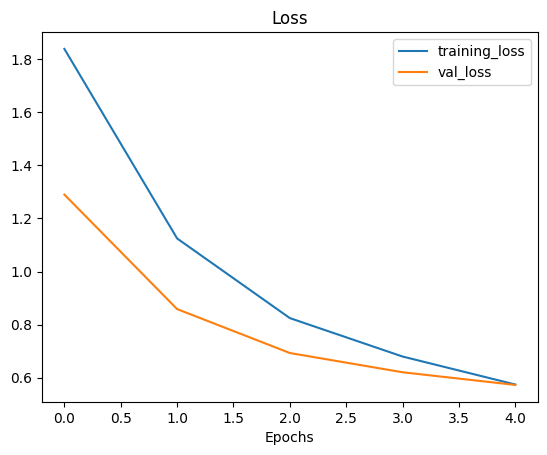

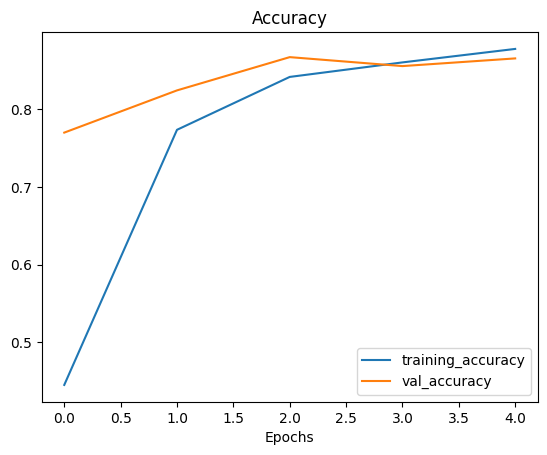

In [21]:

# Check out our model's training curves
plot_loss_curves(history_10_percent)

##Getting a feature vector from a trained model

In [22]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")



Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [23]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [24]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-08-21 02:01:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 172.253.119.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   141MB/s    in 0.9s    

2023-08-21 02:01:34 (141 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [28]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


###Adding data augmentation right into the model


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentaion")


(-0.5, 450.5, 515.5, -0.5)

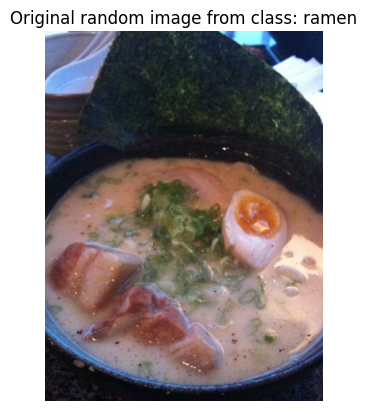

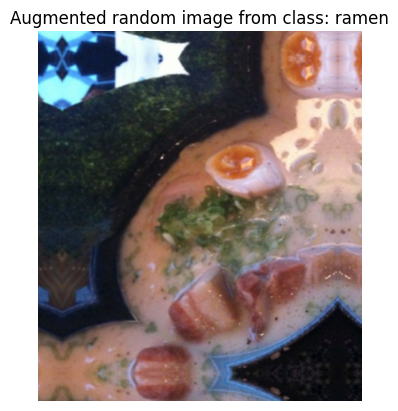

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image= random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
# Augment the image

augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

#Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [42]:
from keras.layers.attention.multi_head_attention import activation
from keras.engine.sequential import training
input_shape=(224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False


inputs = layers.Input(shape = input_shape, name = "input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)
outputs=layers.Dense(10, activation='softmax', name = "output_layer")(x)

model_1=keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps= int(0.25 * len(test_data)),
                    callbacks = [create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230821-030347
Epoch 1/5
3/3 [==============================] - 19s 4s/step - loss: 2.3557 - accuracy: 0.1857 - val_loss: 2.3061 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1227 - accuracy: 0.2571 - val_loss: 2.1669 - val_accuracy: 0.2599
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9564 - accuracy: 0.3429 - val_loss: 2.0732 - val_accuracy: 0.2812
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8068 - accuracy: 0.5000 - val_loss: 1.9859 - val_accuracy: 0.3092
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6798 - accuracy: 0.5857 - val_loss: 1.8999 - val_accuracy: 0.3816


In [43]:

model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentaion (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [44]:

# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 10s 109ms/step - loss: 1.8969 - accuracy: 0.3668


[1.8969252109527588, 0.3668000102043152]

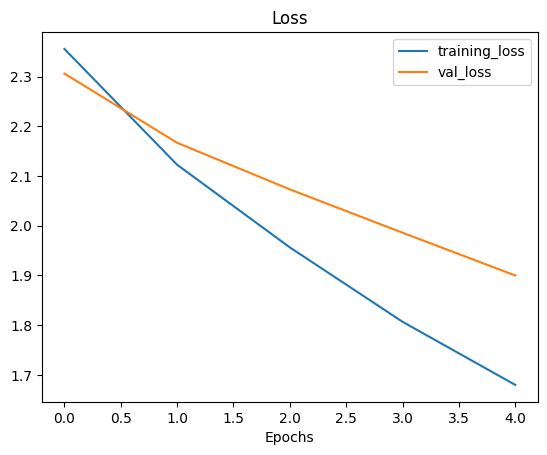

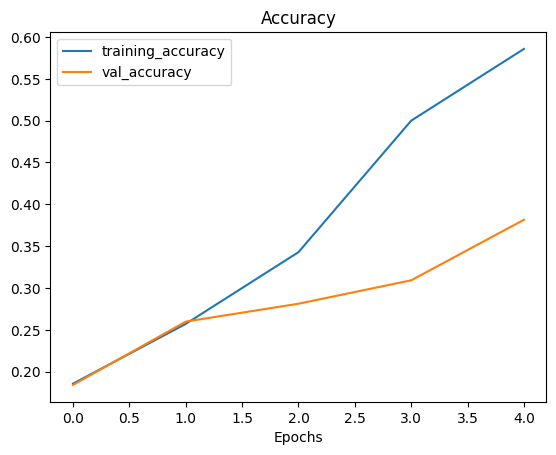

In [45]:

# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

#Model 2: Feature extraction transfer learning with 10% of data and data augmentation


In [8]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [12]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

data_augmentation=keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")


input_shape=(224,224, 3)
# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape = input_shape, name = "input_shape")
x=data_augmentation(inputs)
x=base_model(x, training=False)
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)


# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])


In [13]:

def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    base_model= tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable=training

    inputs = layers.Input(shape=input_shape, name="input_layer")
    x=data_augmentation(inputs),
    x=base_model(x, training=False)
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units = output_shape, activation="softmax", name="outputlayer")(x)
    model=tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()


In [15]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)



In [16]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])



Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230821-070251
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9950 - accuracy: 0.3640
Epoch 1: val_loss improved from inf to 1.48118, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 30s 914ms/step - loss: 1.9950 - accuracy: 0.3640 - val_loss: 1.4812 - val_accuracy: 0.6464
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3916 - accuracy: 0.6507
Epoch 2: val_loss improved from 1.48118 to 1.08265, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 689ms/step - loss: 1.3916 - accuracy: 0.6507 - val_loss: 1.0827 - val_accuracy: 0.7549
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.7173
Epoch 3: val_loss improved from 1.08265 to 0.87858, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [52]:

# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.6647 - accuracy: 0.8184


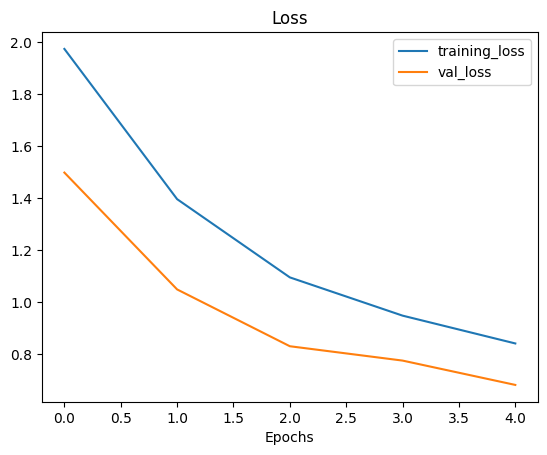

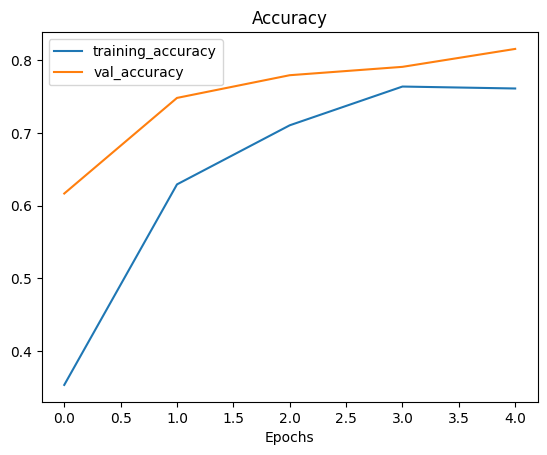

In [53]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [54]:
model_2.load_weights(checkpoint_path)
load_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6647 - accuracy: 0.8184


In [56]:

# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == load_weights_model_results


False

In [57]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(load_weights_model_results))

array([ True,  True])

In [58]:
print(np.array(results_10_percent_data_aug) - np.array(load_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


#Model 3: Fine-tuning an existing model on 10% of the data

In [17]:
model_2.layers

In [18]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")


Layer number: 0 | Layer name: input_layer | Layer type: <keras.engine.input_layer.InputLayer object at 0x7b39ebb12980> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.engine.sequential.Sequential object at 0x7b39ecfd07f0> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x7b3a881ab3d0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b39fa3e2740> | Trainable? True
Layer number: 4 | Layer name: outputlayer | Layer type: <keras.layers.core.dense.Dense object at 0x7b39eb9858d0> | Trainable? True


In [19]:
model_2.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 outputlayer (Dense)         (None, 10)                12810     
                                                           

In [21]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name


'efficientnetv2-b0'

In [22]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)



0


In [24]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [27]:
model_2_base_model.trainable=True
for layer in model_2_base_model.layers[:-10]:
  layer.trainable=False


# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])




In [28]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [29]:
print(len(model_2.trainable_variables))

12


In [31]:
fine_tune_epochs= initial_epochs + 5
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               validation_steps = int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230821-071041
Epoch 5/10
24/24 [==============================] - 31s 652ms/step - loss: 0.7088 - accuracy: 0.8000 - val_loss: 0.5305 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - 14s 562ms/step - loss: 0.5737 - accuracy: 0.8307 - val_loss: 0.4907 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 12s 511ms/step - loss: 0.5564 - accuracy: 0.8253 - val_loss: 0.5042 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 12s 494ms/step - loss: 0.5519 - accuracy: 0.8160 - val_loss: 0.4453 - val_accuracy: 0.8586
Epoch 9/10
24/24 [==============================] - 12s 503ms/step - loss: 0.4609 - accuracy: 0.8627 - val_loss: 0.4835 - val_accuracy: 0.8487
Epoch 10/10
24/24 [==============================] - 12s 471ms/step - loss: 0.4217 - accuracy: 0.8613 - val_loss: 0.4235 - val_accuracy: 0.8750


In [32]:

# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.4314 - accuracy: 0.8592


In [35]:
import matplotlib.pyplot as plt

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


5
11
[0.36399999260902405, 0.6506666541099548, 0.7173333168029785, 0.7706666588783264, 0.7919999957084656, 0.800000011920929, 0.8306666612625122, 0.8253333568572998, 0.8159999847412109, 0.862666666507721, 0.8613333106040955]


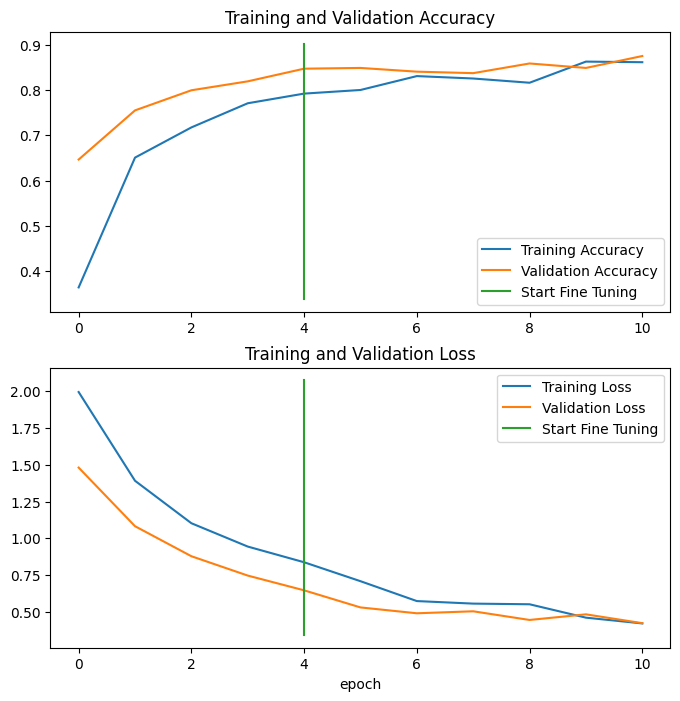

In [36]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)


#Model 4: Fine-tuning an existing model all of the data

In [37]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-08-21 07:26:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   179MB/s    in 2.8s    

2023-08-21 07:26:50 (179 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [38]:

# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")


There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [ ]:
import tensorflow as tf
IMG_SIZE= (224,224)

train_data_10_classes_full= tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)


In [39]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [40]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)


79/79 [==============================] - 9s 104ms/step - loss: 0.4314 - accuracy: 0.8592


[0.4313630759716034, 0.8592000007629395]

In [41]:
results_fine_tune_10_percent


[0.43136298656463623, 0.8592000007629395]

In [42]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning


In [43]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [45]:

model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 outputlayer (Dense)         (None, 10)                12810     
                                                           

In [46]:
print(len(model_2.trainable_variables))


2


In [47]:

# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 66ms/step - loss: 0.6604 - accuracy: 0.8316


[0.6604337692260742, 0.83160001039505]

In [48]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 outputlayer True


In [49]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [50]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [51]:

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])


In [52]:

# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230821-075358
Epoch 5/10
235/235 [==============================] - 99s 377ms/step - loss: 0.7159 - accuracy: 0.7669 - val_loss: 0.3293 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - 73s 308ms/step - loss: 0.5927 - accuracy: 0.8023 - val_loss: 0.3064 - val_accuracy: 0.9046
Epoch 7/10
235/235 [==============================] - 63s 266ms/step - loss: 0.5439 - accuracy: 0.8228 - val_loss: 0.3014 - val_accuracy: 0.9178
Epoch 8/10
235/235 [==============================] - 59s 250ms/step - loss: 0.5036 - accuracy: 0.8343 - val_loss: 0.2759 - val_accuracy: 0.9211
Epoch 9/10
235/235 [==============================] - 55s 232ms/step - loss: 0.4805 - accuracy: 0.8427 - val_loss: 0.2686 - val_accuracy: 0.9178
Epoch 10/10
235/235 [==============================] - 50s 212ms/step - loss: 0.4570 - accuracy: 0.8503 - val_loss: 0.2419 - val_accuracy: 0.9293


In [53]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data


79/79 [==============================] - 9s 93ms/step - loss: 0.2642 - accuracy: 0.9144


[0.26417574286460876, 0.9143999814987183]

In [54]:

results_fine_tune_10_percent

[0.43136298656463623, 0.8592000007629395]

5
11
[0.36399999260902405, 0.6506666541099548, 0.7173333168029785, 0.7706666588783264, 0.7919999957084656, 0.7669333219528198, 0.8022666573524475, 0.8227999806404114, 0.8342666625976562, 0.8426666855812073, 0.850266695022583]


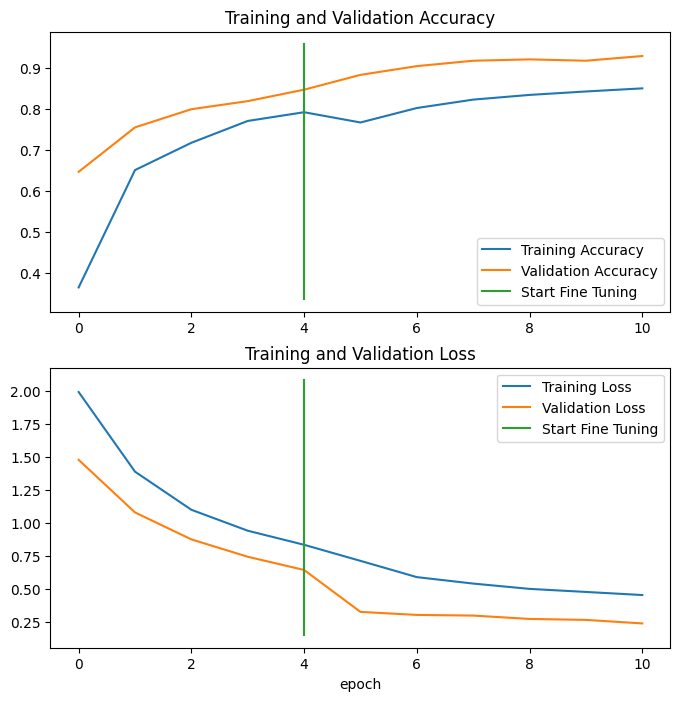

In [55]:

# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)